# Document Description

This notebook is concerned with the trends in the number of days the MJO occurs in each phase (sub and normal) each wet season. This notebook includes the calculations for the trends as well as the plotting of this information>

# Packages

In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
sys.path.append('')
import plotting_functions as pf
import load_dataset as load
import calculation_functions
import phase_calc_functions as phase_calc
from scipy.stats import pearsonr
import mystats
import constants

# Data

In [4]:
rmm_ot = load.load_ot_rmm()
rmm_ot

Opening OT RMM from /g/data/w40/ab2313/mjo_and_rainfall_trend/mjoindex_IHR_20CRV2c.nc


<xarray.Dataset>
Dimensions:    (time: 40177)
Coordinates:
  * time       (time) datetime64[ns] 1905-01-01 1905-01-02 ... 2014-12-31
Data variables:
    t_IHR      (time) float32 ...
    RMM1       (time) float32 ...
    RMM2       (time) float32 ...
    amplitude  (time) float32 ...
    phase      (time) float32 ...
Attributes:
    description:  Reconstructed MJO Index (1905-2014)
    author:       Eric Oliver, Ph.D., Dalhousie University
    date:         2016-Nov-04 14:28:34
    File_Name:    data/mjoindex_IHR.nc
    Title:        Reconstructed MJO Index (1905-2014)
    Source_File:

In [5]:
rmm_wh = load.load_rmm()
rmm_wh

<xarray.Dataset>
Dimensions:    (time: 17769)
Coordinates:
  * time       (time) datetime64[ns] 1974-06-01 1974-06-02 ... 2023-01-23
Data variables:
    RMM1       (time) float64 1.634 1.603 1.516 1.51 ... 0.4908 0.4588 0.4175
    RMM2       (time) float64 1.203 1.015 1.086 1.036 ... -1.53 -1.454 -1.487
    phase      (time) int64 5 5 5 5 5 6 6 6 6 7 6 5 ... 8 8 8 7 8 8 1 2 3 3 3 3
    amplitude  (time) float64 2.029 1.897 1.865 1.831 ... 1.607 1.525 1.544

# Calculations

In [6]:
rmm_wh_ws = phase_calc.wet_season_year(rmm_wh)
rmm_wh_ws = rmm_wh_ws.where(np.logical_and(rmm_wh_ws.phase < 10, rmm_wh_ws.amplitude < 10), np.nan)

rmm_ot_ws = phase_calc.wet_season_year(rmm_ot)
rmm_ot_ws = rmm_ot_ws.where(np.logical_and(rmm_ot_ws.phase < 10, rmm_ot_ws.amplitude < 10), np.nan)
rmm_ot_ws

<xarray.Dataset>
Dimensions:    (time: 13337)
Coordinates:
  * time       (time) datetime64[ns] 1905-01-01 1905-01-02 ... 2015-12-31
Data variables:
    t_IHR      (time) float32 6.958e+05 6.958e+05 ... 7.36e+05 7.36e+05
    RMM1       (time) float32 -0.3303 -0.3193 -0.3354 ... 1.329 1.27 0.8695
    RMM2       (time) float32 1.142 1.288 1.432 1.526 ... -0.3652 -0.1545 0.3881
    amplitude  (time) float32 1.189 1.327 1.471 1.572 ... 1.378 1.279 0.9522
    phase      (time) float32 7.0 7.0 7.0 7.0 7.0 7.0 ... 4.0 4.0 4.0 4.0 5.0
Attributes:
    description:  Reconstructed MJO Index (1905-2014)
    author:       Eric Oliver, Ph.D., Dalhousie University
    date:         2016-Nov-04 14:28:34
    File_Name:    data/mjoindex_IHR.nc
    Title:        Reconstructed MJO Index (1905-2014)
    Source_File:

In [7]:
# Values should range between 1975 and 2021 for wet season
rmm_ot_ws = rmm_ot_ws.where(rmm_ot_ws.time.dt.year.isin(np.arange(1975,2021)), drop = True)
rmm_wh_ws = rmm_wh_ws.where(rmm_wh_ws.time.dt.year.isin(np.arange(1975,2021)), drop = True)

In [8]:
phase_count_wh = phase_calc.count_in_rmm_phase(rmm_wh_ws)
phase_count_wh = calculation_functions.convert_time_to_year(phase_count_wh)
subphase_count_wh = phase_calc.resample_phase_to_subphase(phase_count_wh)

Enhanced phase definition being used [5, 6]


In [9]:
phase_count_ot = phase_calc.count_in_rmm_phase(rmm_ot_ws)
phase_count_ot = calculation_functions.convert_time_to_year(phase_count_ot)
subphase_count_ot = phase_calc.resample_phase_to_subphase(phase_count_ot)
subphase_count_ot

Enhanced phase definition being used [5, 6]


<xarray.Dataset>
Dimensions:  (phase: 4, year: 41)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2011 2012 2013 2014 2015
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    number   (phase, year) int64 16 22 25 12 15 36 22 7 ... 58 25 45 38 24 66 1

In [10]:
phase_count_wh = phase_count_wh.sel(year=slice(1975, 2020))
subphase_count_wh = subphase_count_wh.sel(year=slice(1975, 2020))

In [11]:
phase_count_ot = phase_count_ot.isel(year=slice(None, -1))
subphase_count_ot = subphase_count_ot.isel(year=slice(None, -1))

# Plotting

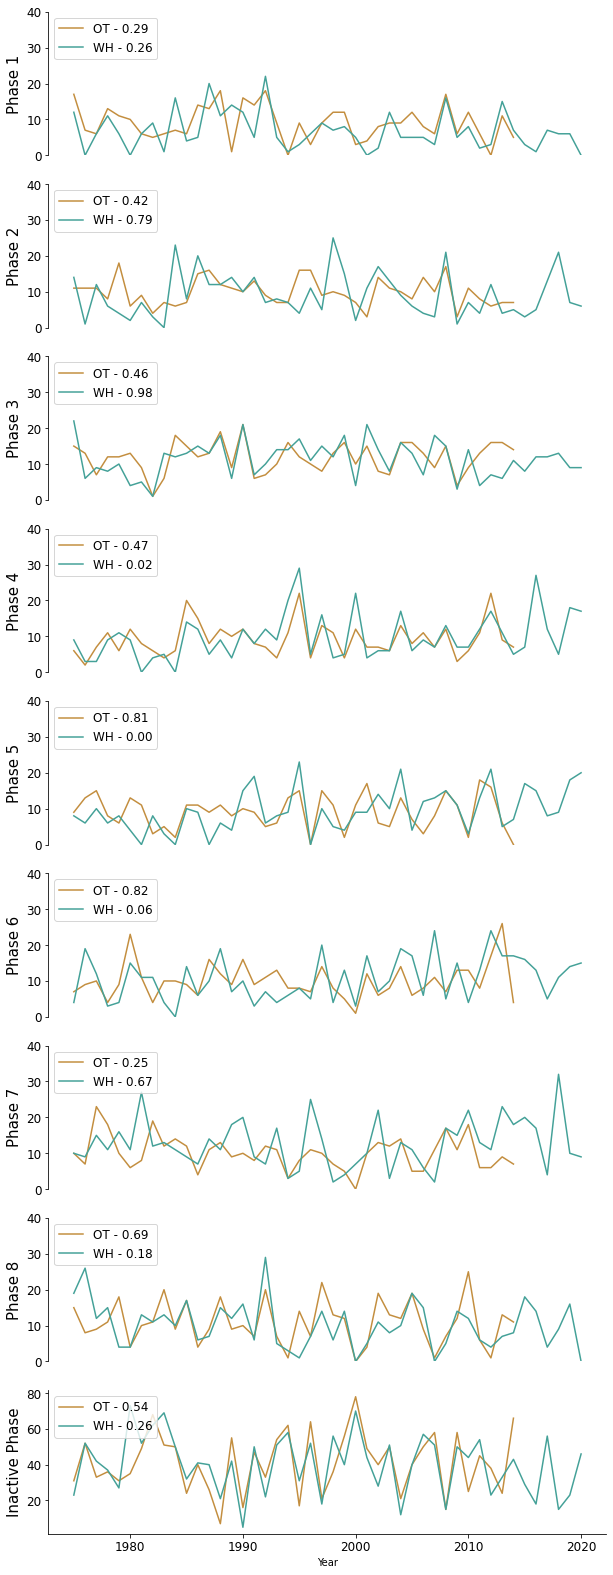

In [19]:
fig = plt.figure(figsize = (10,28))
gs = gridspec.GridSpec(9,1, hspace = 0.2)
DAYS_IN_3_MONTHS = 121

sig_stor = []
x_values_ot = phase_count_ot.year.values
x_values_wh = phase_count_wh.year.values

for i,phase in enumerate(phase_count_ot.phase.values):
    ax = fig.add_subplot(gs[i])
        
    single_phase_ot = phase_count_ot.sel(phase = phase).number
    single_phase_wh = phase_count_wh.sel(phase = phase).number
    
    ot_pvalue = mystats.mann_kendall(single_phase_ot.values)
    wh_pvalue = mystats.mann_kendall(single_phase_wh.values)
    
    ax.plot(x_values_ot, single_phase_ot, color=constants.brown, label=f'OT - {ot_pvalue:.2f}')
    ax.plot(x_values_wh, single_phase_wh, color=constants.green, label=f'WH - {wh_pvalue:.2f}')

    if i == 8:
        ylabel = 'Inactive Phase'
        ax.set_xlabel('Year')

    else:
        ylabel = f'Phase {phase}'
        ax.set_ylim(0,40)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    pf.format_axis(ax)
    ax.set_ylabel(ylabel, fontsize=constants.cbar_title_size)
    leg = ax.legend(loc='upper left', ncol=1, fontsize=constants.ticklabel_size,)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '01_rmm_trend_phase_DecToMarch_OT_and_WH_col1.png')
                         , dpi = 800, bbox_inches = 'tight')

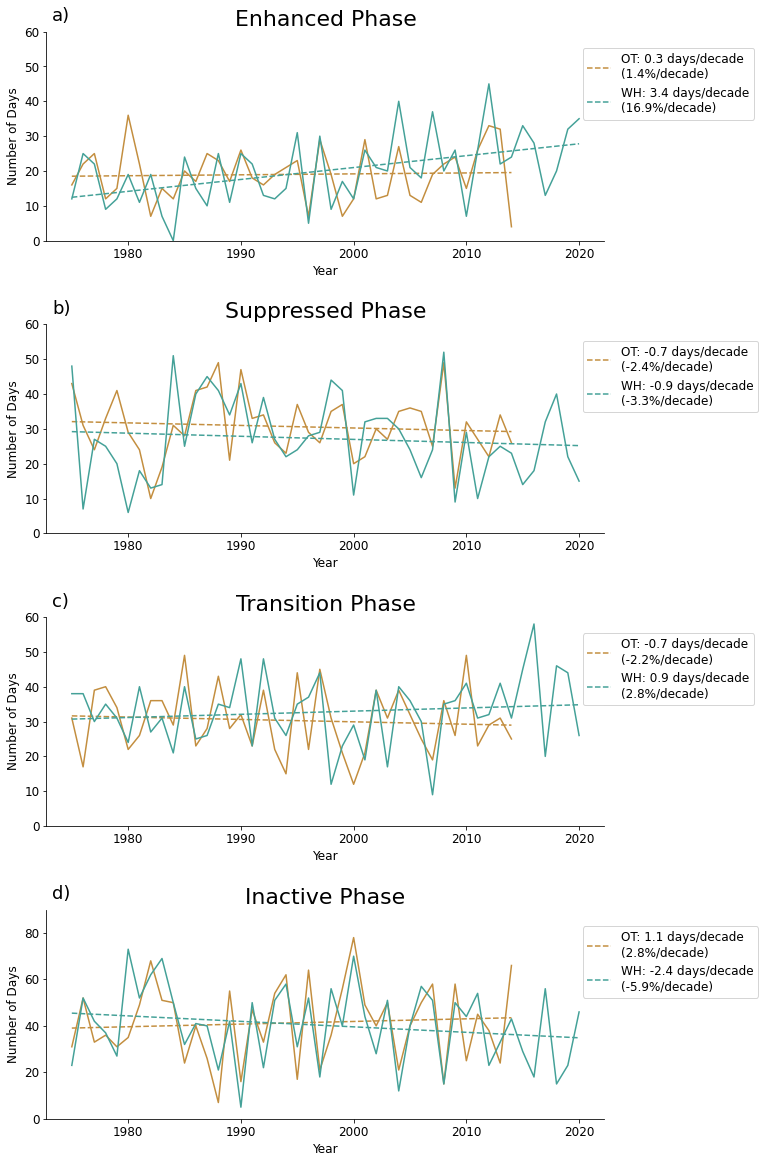

In [22]:
fig, gs = pf.fig_formatter(height_ratios=[1]*4, width_ratios=[1])

for plot_num,phase in enumerate(subphase_count_ot.phase.values):
    ax = fig.add_subplot(gs[plot_num])
    
    single_phase_ot = subphase_count_ot.sel(phase = phase).number
    pf.mjo_single_phase_line_plot(ax, single_phase_ot, linecolor=constants.brown, base_label='OT: ',
                                 color=constants.brown, trendline_color=constants.brown)
    
    single_phase_wh = subphase_count_wh.sel(phase = phase).number
    pf.mjo_single_phase_line_plot(ax, single_phase_wh, linecolor=constants.green, base_label='WH: ',
                                 color=constants.green, trendline_color=constants.green)
    
    if phase == 'inactive':
        ax.set_ylim([0, 90])
        title = 'Inactive Phase'
    else:
        title = f'{phase.capitalize()} Phase'
        ax.set_ylim(0,60)
        
    ax.set_title(title, size=constants.title_size)
    ax.set_ylabel('Number of Days', size=constants.ticklabel_size)
    ax.set_xlabel('Year', size=constants.ticklabel_size)
    leg = ax.legend(loc = 'upper left', ncol=1, fontsize=constants.ticklabel_size, 
                   bbox_to_anchor=[0.95, 0.95])
    pf.format_axis(ax)
    pf.add_figure_label(ax, chr(97+plot_num)+')')

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR, '01_rmm_ot_and_wh_subphase_trends_4x1.png'), 
                         dpi=800, bbox_inches='tight')